### AI Assistance Disclosure
I used ChatGPT (GPT-5 Thinking) for: (a) the soft-voting weight normalization snippet,
(b) the weighted feature-importance aggregation and plot,
(c) pandas Styler coloring pattern, and (d) small syntax/debugging reminders.
I verified and edited all code myself and followed our course patterns.

### **Installing `scikit-learn`**

1. To install `scikit-learn` using `pip`, run the following command: `pip install -U scikit-learn`
2. To install `scikit-learn` using `conda`, run the following command: `conda install -c conda-forge scikit-learn`

In [ ]:
#!pip install -U scikit-learn
#conda install -c conda-forge scikit-learn

In [2]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib
import seaborn as sns                # Seaborn

# scikit-learn
import sklearn
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost

# Partitioning
from sklearn.model_selection import train_test_split

# Visualizing trees
from sklearn import tree

# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score

# Save/load Python objects
import pickle 

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

**Load Dataset**


In [3]:
fetal_df = pd.read_csv("fetal_health.csv")
fetal_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [4]:
# Drop Nulls
fetal_df.dropna(inplace=True)

# Target distribution (1=Normal, 2=Suspect, 3=Pathological)
fetal_df['fetal_health'].value_counts().sort_index()

fetal_health
1.0    1655
2.0     295
3.0     176
Name: count, dtype: int64

**Select Input & Output Features**

In [5]:
# Output column for prediction
output = fetal_df['fetal_health'] 

# Input features (all columns except the target)
features = fetal_df.drop(columns=['fetal_health'])

features.shape, output.shape

((2126, 21), (2126,))

### **One-hot Encoding (Not Required for This Dataset)**
All features in the Fetal Health dataset are numeric signal measurements; there are no categorical columns.
Therefore, one-hot encoding is **not** required.  
(If a future dataset includes categoricals, you would apply: `features = pd.get_dummies(features)`.)

### **Train/Test Split**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    features, output, test_size=0.2, stratify=output, random_state=42
)

features.shape, X_train.shape, X_test.shape

((2126, 21), (1700, 21), (426, 21))

### **Define Base Models: RandomForest, DecisionTree, AdaBoost**

In [7]:
rf  = RandomForestClassifier(n_estimators=300, random_state=42)
dt  = DecisionTreeClassifier(random_state=42)
ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.8, random_state=42)

models = [('rf', rf), ('dt', dt), ('ada', ada)]

### **Fit & Evaluate Base Models**
Saves `*_class_report.csv` and `*_confusion_mat.svg` for each model.

In [8]:
def save_report_and_cm(name, y_true, y_pred):
    # Classification report CSV
    rep = classification_report(y_true, y_pred, output_dict=True, digits=4)
    pd.DataFrame(rep).to_csv(f"{name}_class_report.csv", index=True)

    # Confusion matrix SVG (course style)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix — {name.upper()}")
    fig.tight_layout()
    fig.savefig(f"{name}_confusion_mat.svg")
    plt.close(fig)
    return cm

f1_scores = []
trained = {}

for name, clf in models:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1m = f1_score(y_test, y_pred, average='macro')
    f1_scores.append(f1m)
    trained[name] = clf
    print(f"{name} F1-macro: {f1m:.4f}")
    _ = save_report_and_cm(name, y_test, y_pred)

rf F1-macro: 0.8631
dt F1-macro: 0.8160
ada F1-macro: 0.8039


### **Normalize F1-macro Scores → Weights for Soft Voting**

In [9]:
import numpy as np
f1_scores = np.array(f1_scores, dtype=float)
weights = f1_scores / f1_scores.sum()           # normalized F1-macro
weights_dict = {n:w for (n,_), w in zip(models, weights)}
weights, weights_dict

(array([0.34761605, 0.32861116, 0.32377279]),
 {'rf': np.float64(0.3476160515472822),
  'dt': np.float64(0.32861116144894736),
  'ada': np.float64(0.3237727870037705)})

### **Soft Voting Classifier (weighted by normalized F1-macro)**

In [10]:
voter = VotingClassifier(estimators=models, voting='soft', weights=list(weights))
voter.fit(X_train, y_train)

y_pred_v = voter.predict(X_test)

print("Voting Classifier — Classification Report")
print(classification_report(y_test, y_pred_v, digits=4))

# Save report + confusion matrix
rep_v = classification_report(y_test, y_pred_v, output_dict=True, digits=4)
pd.DataFrame(rep_v).to_csv("Voting_class_report.csv", index=True)

cm_v = confusion_matrix(y_test, y_pred_v)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_v)
fig, ax = plt.subplots()
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix — Soft Voting")
fig.tight_layout()
fig.savefig("Voting_confusion_mat.svg")
plt.close(fig)

Voting Classifier — Classification Report
              precision    recall  f1-score   support

         1.0     0.9379    0.9548    0.9463       332
         2.0     0.7308    0.6441    0.6847        59
         3.0     0.8056    0.8286    0.8169        35

    accuracy                         0.9014       426
   macro avg     0.8247    0.8092    0.8160       426
weighted avg     0.8983    0.9014    0.8994       426



### **Weighted Feature Importance (Soft Voting)**
Use the assignment formula: \( F_i = \sum_{m=1}^M w_m \cdot f_i^{(m)} \),  
with \(w_m\) = normalized F1-macro weights and \(f_i^{(m)}\) = feature importances (each re-normalized to sum to 1).

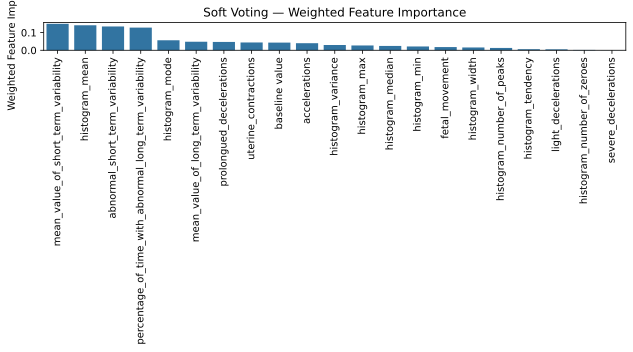

In [11]:
# Collect importances from each base model and re-normalize to sum to 1
imp_rf  = trained['rf'].feature_importances_
imp_dt  = trained['dt'].feature_importances_
imp_ada = trained['ada'].feature_importances_

def renorm(v):
    s = v.sum()
    return v/s if s>0 else v

imp_rf, imp_dt, imp_ada = map(renorm, [imp_rf, imp_dt, imp_ada])

# Weighted sum
weighted_imp = weights[0]*imp_rf + weights[1]*imp_dt + weights[2]*imp_ada

# Plot + save SVG (seaborn style like your roommate)
feat_names = features.columns.to_numpy()
order = np.argsort(weighted_imp)[::-1]

plt.figure(figsize=(9,5))
sns.barplot(x=feat_names[order], y=weighted_imp[order])
plt.xticks(rotation=90)
plt.ylabel("Weighted Feature Importance")
plt.title("Soft Voting — Weighted Feature Importance")
plt.tight_layout()
plt.savefig("voting_feature_imp.svg")
plt.show()

### **Save Trained Models (Pickle)**

In [12]:
with open("rf_fetal.pickle", "wb") as f:   pickle.dump(trained['rf'], f)
with open("dt_fetal.pickle", "wb") as f:   pickle.dump(trained['dt'], f)
with open("ADA_fetal.pickle", "wb") as f:  pickle.dump(trained['ada'], f)
with open("Voting_fetal.pickle", "wb") as f: pickle.dump(voter, f)

["rf_fetal.pickle","dt_fetal.pickle","ADA_fetal.pickle","Voting_fetal.pickle"]


['rf_fetal.pickle',
 'dt_fetal.pickle',
 'ADA_fetal.pickle',
 'Voting_fetal.pickle']

### **Predict on `fetal_health_user.csv` and Color Predicted Class**
Lime = Normal (1) • Yellow = Suspect (2) • Orange = Pathological (3)

In [13]:
user_df = pd.read_csv("fetal_health_user.csv")

# Use the Voting model by default (you can switch to rf/dt/ada if desired)
pred_class = voter.predict(user_df)
pred_prob  = voter.predict_proba(user_df).max(axis=1)

out_df = user_df.copy()
out_df["Predicted Class"] = pred_class
out_df["Prediction Probability"] = pred_prob

def color_pred_series(s):
    colors = []
    for v in s:
        if v == 1: colors.append("background-color: lime")     # Normal
        elif v == 2: colors.append("background-color: yellow")  # Suspect
        elif v == 3: colors.append("background-color: orange")  # Pathological
        else: colors.append("")
    return colors

out_df.style.apply(color_pred_series, subset=["Predicted Class"]) \
            .format({"Prediction Probability": "{:.3f}"})

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,Predicted Class,Prediction Probability
0,123,0.004000,0.000000,0.005000,0.005000,0,0.000000,24,1.300000,0,2.100000,56,92,148,3,0,121,123,125,7,0,1.000000,0.798
1,123,0.000000,0.000000,0.005000,0.004000,0,0.000000,47,1.100000,31,7.400000,130,59,189,14,2,129,122,127,15,0,1.000000,0.760
2,123,0.000000,0.000000,0.005000,0.005000,0,0.000000,50,0.800000,32,3.100000,94,75,169,7,0,125,122,126,8,0,1.000000,0.753
3,123,0.000000,0.000000,0.005000,0.006000,0,0.000000,45,1.000000,19,3.800000,85,59,144,8,1,124,119,125,14,1,1.000000,0.787
4,123,0.006000,0.000000,0.006000,0.004000,0,0.000000,33,1.300000,0,4.700000,138,61,199,9,1,135,122,127,39,0,1.000000,0.798
5,138,0.000000,0.009000,0.002000,0.002000,0,0.000000,60,0.500000,9,8.700000,47,103,150,3,0,144,140,144,4,1,2.000000,0.766
6,141,0.000000,0.017000,0.002000,0.002000,0,0.000000,60,0.400000,41,5.600000,38,121,159,3,0,154,149,154,8,1,2.000000,0.786
7,141,0.005000,0.023000,0.002000,0.001000,0,0.000000,53,1.000000,28,5.200000,123,57,180,13,0,154,149,154,10,1,2.000000,0.692
8,141,0.001000,0.020000,0.001000,0.001000,0,0.000000,59,0.500000,38,6.100000,38,121,159,3,0,154,149,154,8,1,2.000000,0.749
9,129,0.000000,0.001000,0.006000,0.009000,0,0.001000,65,2.800000,0,0.000000,101,50,151,7,2,105,88,112,13,0,3.000000,0.785


In [14]:
out_df.to_csv("Voting_user_predictions.csv", index=False)
"Saved: Voting_user_predictions.csv"

'Saved: Voting_user_predictions.csv'